# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

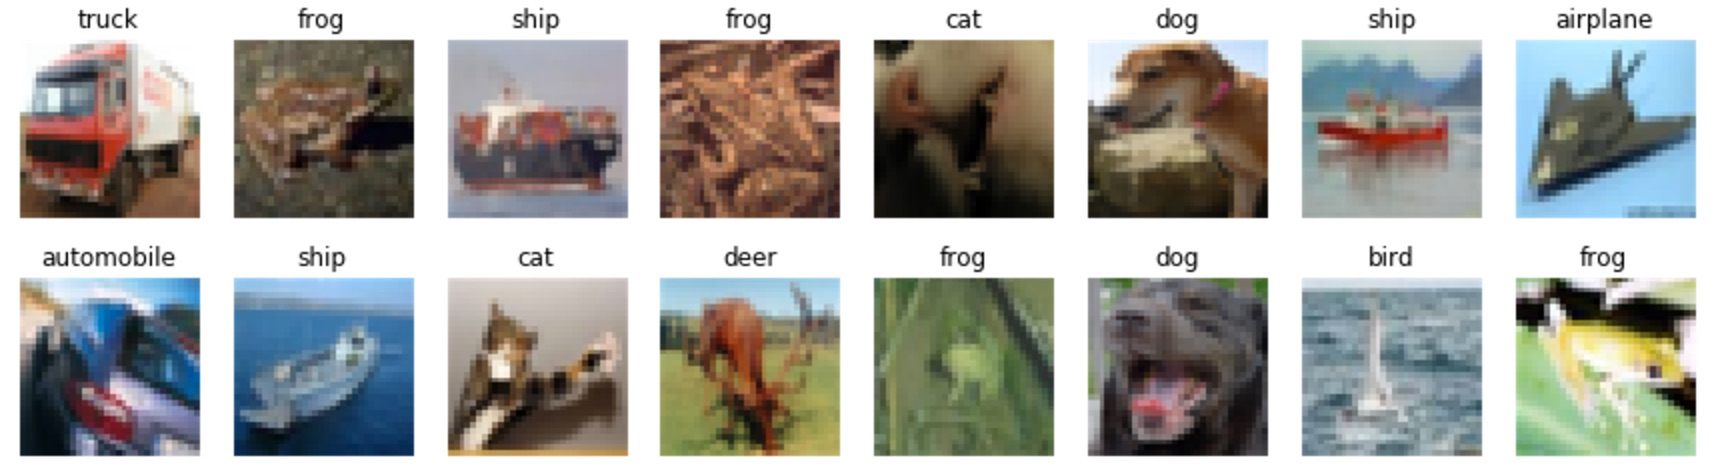

In [1]:
from IPython.display import Image

Image(filename='cifar10.jpg')

In [2]:
# !wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

In [3]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

(40000, 3, 32, 32) (40000,)


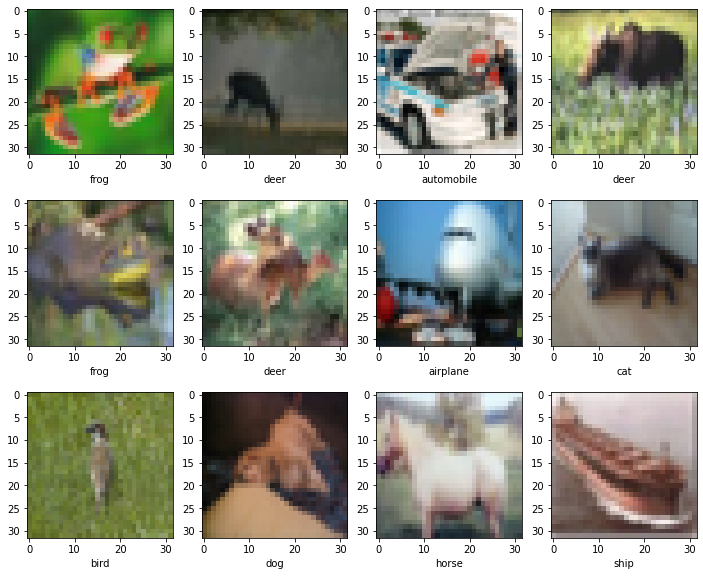

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [5]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [6]:
cuda_availability = torch.cuda.is_available()
if cuda_availability:
  device = torch.device('cuda:{}'.format(torch.cuda.current_device()))
else:
  device = 'cpu'

Let's start with a dense network for our baseline:

In [7]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

In [8]:
model = model.to(device)

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [9]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32, device=device)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64, device=device)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [10]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.3846, device='cuda:0', grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [11]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [12]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

In [13]:
def train():
    train_loss = []
    val_accuracy = []
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
            # train on batch
            loss = compute_loss(X_batch, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.item())

        # And a full pass over the validation data:
        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
            logits = model(torch.as_tensor(X_batch, dtype=torch.float32, device=device))
            y_pred = logits.max(1)[1].data.cpu().numpy()
            val_accuracy.append(np.mean((y_batch == y_pred)))


        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(X_train) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

In [14]:
import time
num_epochs = 10 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

train()

Epoch 1 of 10 took 1.000s
  training loss (in-iteration): 	2.053700
  validation accuracy: 			33.20 %
Epoch 2 of 10 took 1.009s
  training loss (in-iteration): 	1.863755
  validation accuracy: 			36.26 %
Epoch 3 of 10 took 0.994s
  training loss (in-iteration): 	1.790640
  validation accuracy: 			38.36 %
Epoch 4 of 10 took 0.960s
  training loss (in-iteration): 	1.743773
  validation accuracy: 			40.50 %
Epoch 5 of 10 took 0.971s
  training loss (in-iteration): 	1.706766
  validation accuracy: 			40.14 %
Epoch 6 of 10 took 1.009s
  training loss (in-iteration): 	1.672311
  validation accuracy: 			41.51 %
Epoch 7 of 10 took 1.010s
  training loss (in-iteration): 	1.643156
  validation accuracy: 			43.01 %
Epoch 8 of 10 took 1.004s
  training loss (in-iteration): 	1.618571
  validation accuracy: 			43.13 %
Epoch 9 of 10 took 0.982s
  training loss (in-iteration): 	1.594730
  validation accuracy: 			44.52 %
Epoch 10 of 10 took 0.966s
  training loss (in-iteration): 	1.575527
  validation 

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.


### Final test

In [15]:
def get_accuracy():
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc = []
    for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
        logits = model(torch.as_tensor(X_batch, device=device, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.cpu().numpy()
        test_batch_acc.append(np.mean(y_batch == y_pred))

    test_accuracy = np.mean(test_batch_acc)

    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(
        test_accuracy * 100))

    if test_accuracy * 100 > 95:
        print("Double-check, than consider applying for NIPS'17. SRSly.")
    elif test_accuracy * 100 > 90:
        print("U'r freakin' amazin'!")
    elif test_accuracy * 100 > 80:
        print("Achievement unlocked: 110lvl Warlock!")
    elif test_accuracy * 100 > 70:
        print("Achievement unlocked: 80lvl Warlock!")
    elif test_accuracy * 100 > 60:
        print("Achievement unlocked: 70lvl Warlock!")
    elif test_accuracy * 100 > 50:
        print("Achievement unlocked: 60lvl Warlock!")
    else:
        print("We need more magic! Follow instructons below")

In [16]:
get_accuracy()

Final results:
  test accuracy:		44.42 %
We need more magic! Follow instructons below


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [17]:
model = nn.Sequential(
    nn.Conv2d(3, 10, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)), 
    Flatten(),
    nn.Linear(2250, 100),
    nn.Dropout2d(0.1),
    nn.Linear(100, 10),
)

In [18]:
model = model.to(device)

In [19]:
opt = torch.optim.Adam(model.parameters())

In [20]:
num_epochs = 10 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

train()

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 of 10 took 1.807s
  training loss (in-iteration): 	1.654909
  validation accuracy: 			47.85 %
Epoch 2 of 10 took 1.655s
  training loss (in-iteration): 	1.419697
  validation accuracy: 			50.60 %
Epoch 3 of 10 took 1.670s
  training loss (in-iteration): 	1.327758
  validation accuracy: 			53.56 %
Epoch 4 of 10 took 1.687s
  training loss (in-iteration): 	1.279414
  validation accuracy: 			54.21 %
Epoch 5 of 10 took 1.698s
  training loss (in-iteration): 	1.245011
  validation accuracy: 			55.05 %
Epoch 6 of 10 took 1.975s
  training loss (in-iteration): 	1.214475
  validation accuracy: 			56.37 %
Epoch 7 of 10 took 1.625s
  training loss (in-iteration): 	1.188154
  validation accuracy: 			56.54 %
Epoch 8 of 10 took 1.736s
  training loss (in-iteration): 	1.169998
  validation accuracy: 			55.19 %
Epoch 9 of 10 took 1.725s
  training loss (in-iteration): 	1.149864
  validation accuracy: 			56.69 %
Epoch 10 of 10 took 1.642s
  training loss (in-iteration): 	1.130322
  validation 

In [21]:
get_accuracy()

Final results:
  test accuracy:		57.22 %
Achievement unlocked: 60lvl Warlock!


## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [22]:
model = nn.Sequential(
    nn.Conv2d(3, 10, kernel_size=(3, 3)),
    nn.BatchNorm2d(10),
    nn.MaxPool2d(kernel_size=(2, 2)), 
    nn.ReLU(),
    Flatten(),
    nn.Linear(2250, 100),
    nn.BatchNorm1d(100),
    nn.Dropout2d(0.1),
    nn.Linear(100, 10),
)

model = model.to(device)

In [23]:
opt = torch.optim.Adam(model.parameters())

num_epochs = 10 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

train()

Epoch 1 of 10 took 2.231s
  training loss (in-iteration): 	1.441057
  validation accuracy: 			54.65 %
Epoch 2 of 10 took 2.196s
  training loss (in-iteration): 	1.213362
  validation accuracy: 			45.83 %
Epoch 3 of 10 took 2.157s
  training loss (in-iteration): 	1.136647
  validation accuracy: 			58.12 %
Epoch 4 of 10 took 2.181s
  training loss (in-iteration): 	1.088761
  validation accuracy: 			55.65 %
Epoch 5 of 10 took 2.251s
  training loss (in-iteration): 	1.061885
  validation accuracy: 			56.49 %
Epoch 6 of 10 took 2.208s
  training loss (in-iteration): 	1.035414
  validation accuracy: 			53.05 %
Epoch 7 of 10 took 2.192s
  training loss (in-iteration): 	1.017440
  validation accuracy: 			58.74 %
Epoch 8 of 10 took 2.167s
  training loss (in-iteration): 	1.003234
  validation accuracy: 			57.65 %
Epoch 9 of 10 took 2.312s
  training loss (in-iteration): 	0.994333
  validation accuracy: 			57.65 %
Epoch 10 of 10 took 2.340s
  training loss (in-iteration): 	0.981845
  validation 

In [24]:
get_accuracy()

Final results:
  test accuracy:		52.74 %
Achievement unlocked: 60lvl Warlock!


# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or with weight_decay parameter of a optimizer ([for example SGD's doc](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   

## Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [25]:
from torchvision import transforms

means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [26]:
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split, Dataset

In [27]:
class DatasetFromSubset(Dataset):
    """
    https://discuss.pytorch.org/t/torch-utils-data-dataset-random-split/32209/3
    """
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [28]:
train_val_data = CIFAR10("./cifar_data/", train=True)

val_part = int(0.1 * len(train_val_data))
train_part = len(train_val_data) - val_part

train_subset, val_subset  = random_split(train_val_data, [train_part, val_part])

train_loader = DatasetFromSubset(train_subset, transform=transform_augment)
val_loader = DatasetFromSubset(val_subset, transform=transform_test)
test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)

In [ ]:
num_workers = 0 if device == 'cpu' else 4
pin_memory = False

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                      batch_size=batch_size,
                                      shuffle=True,
                                      num_workers=num_workers,
                                      pin_memory=pin_memory)

val_batch_gen = torch.utils.data.DataLoader(val_loader, 
                                      batch_size=batch_size,
                                      shuffle=True,
                                      num_workers=num_workers,
                                      pin_memory=pin_memory)

test_batch_gen = torch.utils.data.DataLoader(test_loader,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      num_workers=num_workers,
                                      pin_memory=pin_memory)

In [29]:
def get_accuracy(model, test_batch_gen):
    model.train(False)
    test_batch_acc = []
    for X_batch, y_batch in test_batch_gen:
        X_batch = X_batch.to(device, non_blocking=True)
        logits = model(X_batch)
        y_pred = logits.max(1)[1].data.cpu().numpy()
        test_batch_acc.append(np.mean(y_batch.cpu().numpy() == y_pred))


    test_accuracy = np.mean(test_batch_acc)

    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(
        test_accuracy * 100))

    if test_accuracy * 100 > 95:
        print("Double-check, than consider applying for NIPS'17. SRSly.")
    elif test_accuracy * 100 > 90:
        print("U'r freakin' amazin'!")
    elif test_accuracy * 100 > 80:
        print("Achievement unlocked: 110lvl Warlock!")
    elif test_accuracy * 100 > 70:
        print("Achievement unlocked: 80lvl Warlock!")
    elif test_accuracy * 100 > 60:
        print("Achievement unlocked: 70lvl Warlock!")
    elif test_accuracy * 100 > 50:
        print("Achievement unlocked: 60lvl Warlock!")
    else:
        print("We need more magic!")

In [30]:
def train_with_augmentation(model, opt, batch_size=512, patience=10, num_epochs=10, model_name='simple_model'):
    train_loss_ar = []
    val_accuracy_ar = []
    
    trigger_times = 0

    prev_val_accuracy = -np.Inf
    val_accuracy_max = -np.Inf

    num_workers = 0 if device == 'cpu' else 4
    pin_memory = False
    
    train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers,
                                          pin_memory=pin_memory)

    val_batch_gen = torch.utils.data.DataLoader(val_loader, 
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers,
                                          pin_memory=pin_memory)

    test_batch_gen = torch.utils.data.DataLoader(test_loader,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers,
                                          pin_memory=pin_memory)

    for epoch in range(num_epochs):
        start_time = time.time()
        
        model.train(True)
        for X_batch, y_batch in train_batch_gen:
            X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
            loss = compute_loss(X_batch, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad(set_to_none=True)
            train_loss_ar.append(loss.item())

        model.train(False)
        for X_batch, y_batch in val_batch_gen:
            X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
            logits = model(torch.as_tensor(X_batch, dtype=torch.float32, device=device))
            y_pred = logits.max(1)[1].data.cpu().numpy()
            val_accuracy_ar.append(np.mean((y_batch.cpu().numpy() == y_pred)))
            

        val_accuracy = np.mean(val_accuracy_ar[-len(X_val) // batch_size:])

        if val_accuracy > val_accuracy_max:
            torch.save({
                'epoch': epoch,
                'valid_accuracy': val_accuracy,
                'state_dict': model.state_dict(),
                'optimizer': opt.state_dict(),
            }, 'models/' + model_name + f'_{epoch}.pth')

            val_accuracy_max = val_accuracy

        if val_accuracy < prev_val_accuracy:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping\n')
                get_accuracy(model, test_batch_gen)
                return 0
        else:
            trigger_times = 0

        prev_val_accuracy = val_accuracy


        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss_ar[-len(X_train) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            val_accuracy * 100))
        
    get_accuracy(model, test_batch_gen)